## About

### Notebook Overview

This notebook involves setting up and implementing real-time text-to-speech and streaming functionalities. It provides a step-by-step guide on preparing the necessary environment, defining essential functions, and integrating these components into a cohesive main program.

### Key Steps

1. **Text-to-Speech**: Demonstrating the implementation of text-to-speech functionality.

2. **Streaming**: Showing how to set up and manage real-time video and audio streaming.

3. **Main Program**: Integrating all components into a cohesive main program for real-time processing.


### Objective

The objective is to efficiently set up, manage, and implement real-time text-to-speech and streaming functionalities, making use of appropriate tools and techniques to handle real-time audio processing tasks effectively.

## Letters

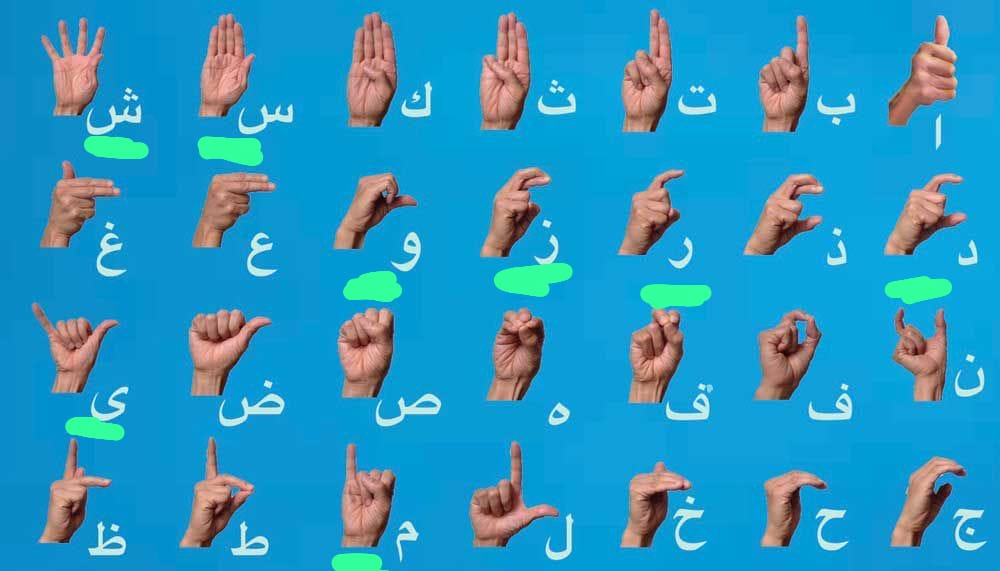

**Letters Mapping**

0 ل

م 1

2 ر

س 3

4 ش

5 و

6 ي

ز 7

## Setting Up

In [1]:
from IPython.display import display, Javascript, Audio
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from PIL import Image
import io

In [2]:
from IPython import get_ipython

In [3]:
import re

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [5]:
from google.colab import drive, output

In [6]:
!pip install gtts

In [7]:
from gtts import gTTS

In [8]:
!pip install torch torchvision opencv-python

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [10]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Text-to-Speech Functions



In [ ]:
#function
def say(text, speech_file_path):
    tts = gTTS(text=text, lang='ar')

    # Save the audio to a file
    tts.save(speech_file_path)

In [ ]:
# test
say('مرحبا', 'response.mp3')

## Streaming Functions

In [ ]:
# Function to handle JavaScript message
def handle_js_message(msg):
    global flag
    if msg['content']['data']['flag'] == 1:
        flag = 1
        print("Flag set to 1 by JavaScript")

# Register the message handler
get_ipython().kernel.comm_manager.register_target('flag_comm', handle_js_message)

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        var flag = 0;

        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            const stop = document.createElement('button');
            stop.textContent = 'Stop';
            const returnEmpty = document.createElement('button');
            returnEmpty.textContent = 'Space';
            div.appendChild(capture);
            div.appendChild(stop);
            div.appendChild(returnEmpty);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            let photoData = null;

            capture.onclick = () => {
                const canvas = document.createElement('canvas');
                canvas.width = video.videoWidth;
                canvas.height = video.videoHeight;
                canvas.getContext('2d').drawImage(video, 0, 0);
                photoData = canvas.toDataURL('image/jpeg', quality);
                stream.getVideoTracks()[0].stop();
                div.remove();
            };

            stop.onclick = () => {
                stream.getVideoTracks()[0].stop();
                div.remove();
                flag = 1;
                google.colab.kernel.invokeFunction('flag_comm', {flag: 1}, {});
            };

            returnEmpty.onclick = () => {
                stream.getVideoTracks()[0].stop();
                div.remove();
                flag = 2;
                google.colab.kernel.invokeFunction('flag_comm', {flag: 2}, {});
            };

            // Wait for either the capture or stop button to be clicked
            while (!photoData && !flag) {
                await new Promise(resolve => setTimeout(resolve, 100));
            }

            return {photoData: photoData, flag: flag};
        }
    ''')
    display(js)
    result = eval_js('takePhoto({})'.format(quality))

    if result['flag'] == 1:
        #print("Video stream stopped without capturing a photo.")
        global flag
        flag = 1
        return None
    elif result['flag'] == 2:
        print("Space")
        flag = 2
        return " "

    if result['photoData'] is None:
        #print("No photo captured.")
        return None

    binary = b64decode(result['photoData'].split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)

    return filename

def stop_stream():
    js = Javascript('''
        function stopStream() {
            const videoElements = document.querySelectorAll('video');
            videoElements.forEach(video => {
                const stream = video.srcObject;
                const tracks = stream.getTracks();

                tracks.forEach(track => track.stop());
                video.remove();
            });
            google.colab.kernel.invokeFunction('flag_comm', {flag: 1}, {});
        }
        stopStream();
    ''')
    display(js)

## Functions for Main Program

In [ ]:
# Function to preprocess the captured image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [ ]:
# Function to predict the sign language letter
def predict_sign(image_path):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
    predicted_class = output.argmax(dim=1).item()
    return predicted_class

In [ ]:
def contains_letter(s):
    # Arabic Unicode range: \u0600-\u06FF
    return bool(re.search('[\u0600-\u06FF]', s))

## Important definings for Main Program

### 30% data

In [ ]:
class_mapping = {
    0: 'Lam',
    1: 'Meem',
    2: 'Reh',
    3: 'Seen',
    4: 'Sheen',
    5: 'Waw',
    6: 'Yeh',
    7: 'Zain'
}

In [ ]:
class_mapping2 = {
    0: 'ل',
    1: 'م',
    2: 'ر',
    3: 'س',
    4: 'ش',
    5: 'و',
    6: 'ي',
    7: 'ز'
}

In [ ]:
# Load the pre-trained PyTorch model
model_path = '/content/drive/Shareddrives/Computer Vision/Trained models/resnet18.pth'  # Update this path
model = torch.load(model_path)
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size according to your model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

NameError: name 'torch' is not defined

### All data

In [ ]:
class_mapping = {
    0: 'Zain',
    1: 'Zah',
    2: 'Meem',
    3: 'Seen',
    4: 'Teh',
    5: 'Lam',
    6: 'Dad',
    7: 'Teh_Marbuta',
    8: 'Reh',
    9: 'Sad',
    10: 'Dal',
    11: 'Sheen',
    12: 'Hah',
    13: 'Beh',
    14: 'Tah',
    15: 'Alef',
    16: 'Waw',
    17: 'Qaf',
    18: 'Al',
    19: 'Ghain',
    20: 'Heh',
    21: 'Ain',
    22: 'Kaf',
    23: 'Thal',
    24: 'Feh',
    25: 'Khah',
    26: 'Yeh',
    27: 'Jeem',
    28: 'Theh',
    29: 'Noon',
    30: 'Laa'}

In [ ]:
class_mapping2 = {
    0: 'ز',
    1: 'ظ',
    2: 'م',
    3: 'س',
    4: 'ت',
    5: 'ل',
    6: 'ض',
    7: 'ة',
    8: 'ر',
    9: 'ص',
    10: 'د',
    11: 'ش',
    12: 'ح',
    13: 'ب',
    14: 'ط',
    15: 'ا',
    16: 'و',
    17: 'ق',
    18: 'ال',
    19: 'غ',
    20: 'ه',
    21: 'ع',
    22: 'ك',
    23: 'ذ',
    24: 'ف',
    25: 'خ',
    26: 'ي',
    27: 'ج',
    28: 'ث',
    29: 'ن',
    30: 'لا'}

In [ ]:
# Load the pre-trained PyTorch model
model_path = '/content/drive/Shareddrives/Computer Vision/Trained models/resnet_cpu (1).pth'  # Update this path
model = torch.load(model_path)
model.eval()

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust the size according to your model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Main Program

<IPython.core.display.Javascript object>

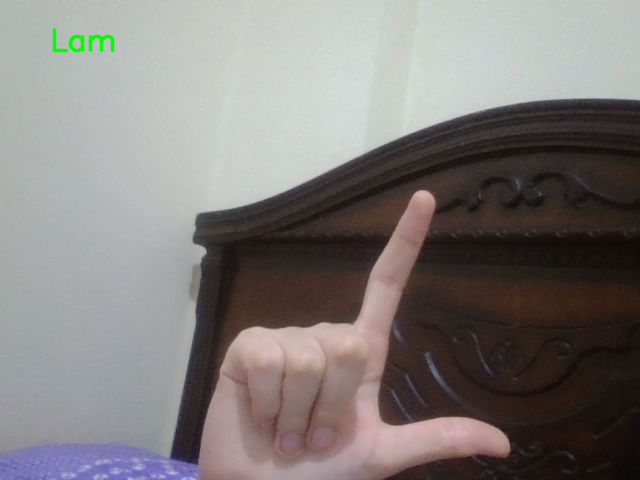

<IPython.core.display.Javascript object>

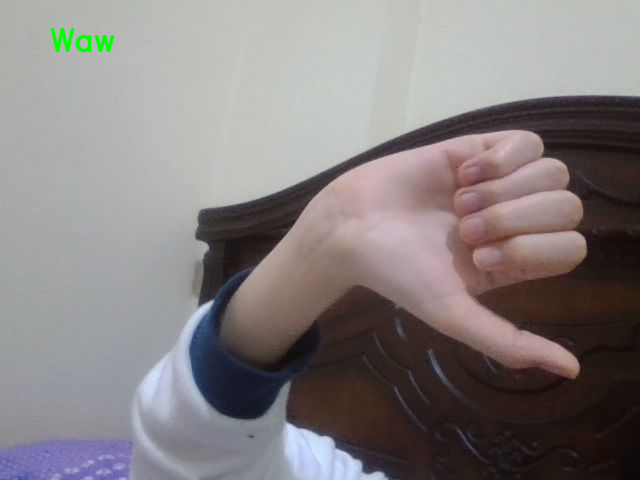

<IPython.core.display.Javascript object>

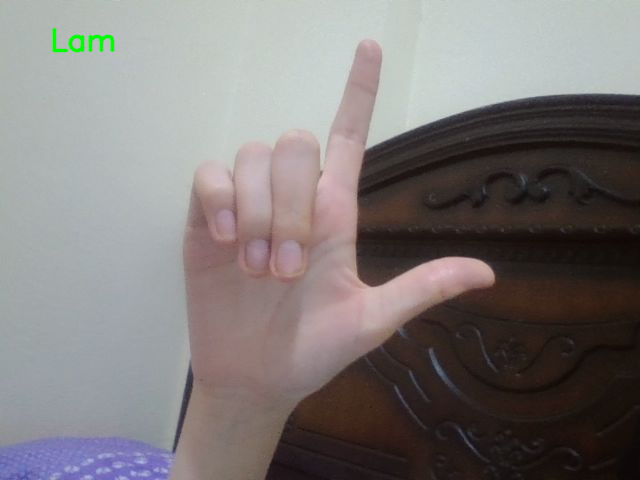

<IPython.core.display.Javascript object>

Space


<IPython.core.display.Javascript object>

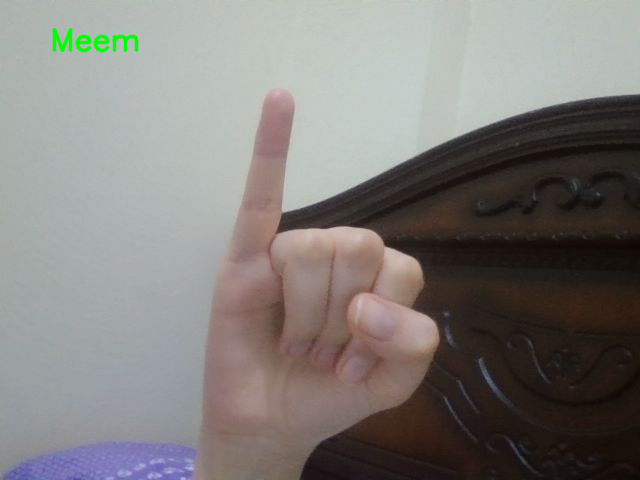

<IPython.core.display.Javascript object>

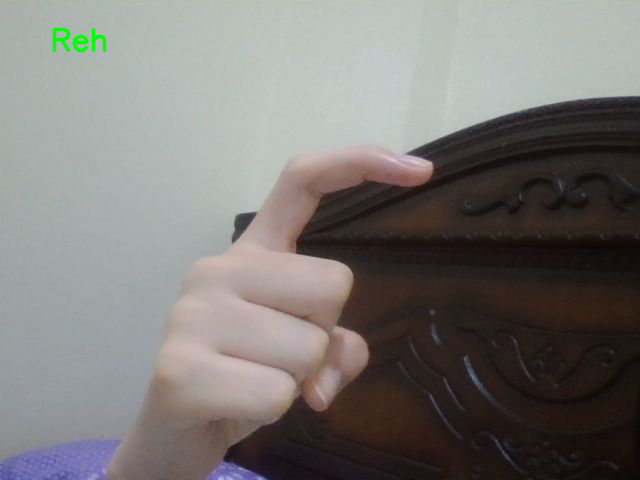

<IPython.core.display.Javascript object>

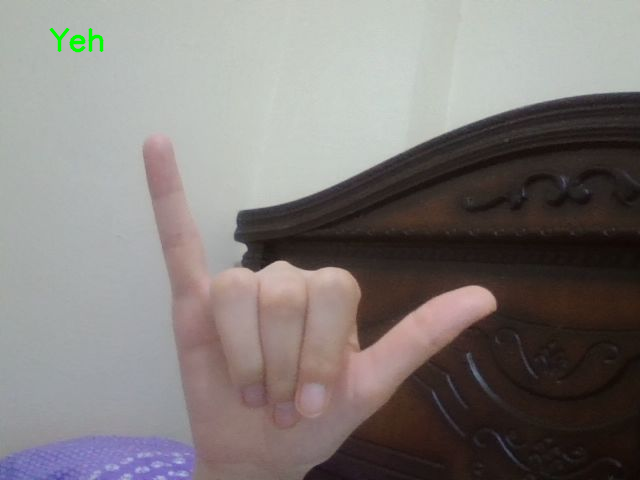

<IPython.core.display.Javascript object>

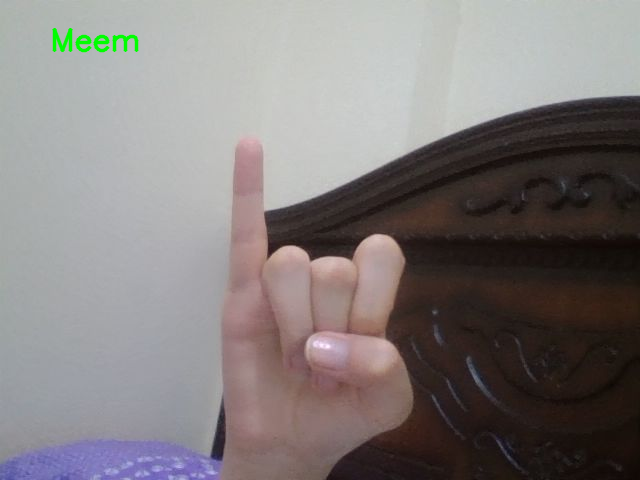

<IPython.core.display.Javascript object>

لول مريم


In [ ]:
# Global flag
flag = 0

all = ''

while(flag != 1):
  image_file = take_photo()
  if image_file != None and image_file != ' ':
      #print(f"Photo saved to {image_file}")


      # Convert to OpenCV format
      image = cv2.imread(image_file)

      # Predict the sign language letter
      predicted_class = predict_sign(image_file)

      if predicted_class is not None:
        letter = class_mapping2[predicted_class]
        all = all + letter
        predicted_class = class_mapping[predicted_class]
      # Display the prediction on the image
      cv2.putText(image, str(predicted_class), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

      # Convert the image to RGB format for displaying
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Display the image with the prediction
      display(Image.fromarray(image_rgb))
  elif (flag == 2):
      all = all + " "
  else:
      print(all)
      # Display Audio
      if contains_letter(all):
        voice = say(all, "voice.mp3")
        display(Audio("voice.mp3", autoplay=True))

# Try!

In [ ]:
# Global flag
flag = 0

all = ''

while(flag != 1):
  image_file = take_photo()
  if image_file != None and image_file != ' ':
      #print(f"Photo saved to {image_file}")


      # Convert to OpenCV format
      image = cv2.imread(image_file)

      # Predict the sign language letter
      predicted_class = predict_sign(image_file)

      if predicted_class is not None:
        letter = class_mapping2[predicted_class]
        all = all + letter
        predicted_class = class_mapping[predicted_class]
      # Display the prediction on the image
      cv2.putText(image, str(predicted_class), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

      # Convert the image to RGB format for displaying
      image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # Display the image with the prediction
      display(Image.fromarray(image_rgb))
  elif (flag == 2):
      all = all + " "
  else:
      print(all)
      # Display Audio
      if contains_letter(all):
        voice = say(all, "voice.mp3")
        display(Audio("voice.mp3", autoplay=True))

NameError: name 'Javascript' is not defined